In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

import nltk
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

In [2]:
file1 = 'data/QueryResults3_new.csv'
df1 = pd.read_csv(file1,index_col=['Id'])

import mes_fonctions_final2 as stt

In [3]:
StopWord = stt.load_stop_word()

# Chargement des Tags
> Nous chargeons les tags transformés en Dummy features (une colonne par tag en binaire)
>
> Nous n'allons considérer que les tags cités au moins 300 fois (en dessous la représentation risque de n'être pas suffisamment bonne)

In [4]:
Y_tags, Y_tags_voc = stt.genere_target_dummy_and_vocabulary(data=df1, min_df=300)
Tags_freq = stt.genere_df_target_tags_freq(data=df1, min_df=300)

/!\ Ajout des features en cours


# Rappel des fonctions utiles

In [36]:
from nltk.stem.snowball import EnglishStemmer
stemmer = EnglishStemmer()

def preProcess_remove_Code(html_in):
    # Chargement du module BeautifulSoup pour le parsing des données HTML
    from bs4 import BeautifulSoup
    html_in_soup = BeautifulSoup(html_in, 'html.parser')

    # Suppression des blocs de Code
    for h_code in html_in_soup.find_all('code'):
        h_code.decompose()

    return html_in_soup.get_text().lower()


def preProcess_keep_Code(html_in):
    # Chargement du module BeautifulSoup pour le parsing des données HTML
    from bs4 import BeautifulSoup
    html_in_soup = BeautifulSoup(html_in, 'html.parser')

    return html_in_soup.get_text().lower()

# Le préprocessing :
#   - nettoie le html
#   - supprime les blocs de Code
#   - ne prend que la partie textuelle du html
#   - renvoie ce texte en minuscule


def preProcess(html_in):
    # Chargement du module BeautifulSoup pour le parsing des données HTML
    from bs4 import BeautifulSoup
    html_in_soup = BeautifulSoup(html_in, 'html.parser')

    # Suppression des blocs de Code
    for h_code in html_in_soup.find_all('code'):
        h_code.decompose()

    return html_in_soup.get_text().lower()


# Réalisation du stemming (on coupe les racines)
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


# La tokenisation :


def tokenize(text):
    m_token_pattern = r"((?:(?:(?:[0-9a-zA-Z])\.){2,}[a-zA-Z])" +\
        "|(?:(?:[0-9a-zA-Z]){2,}\.(?:[0-9a-zA-Z]){2,}" +\
        "|(?:\.(?:[0-9a-zA-Z]){2,}))" +\
        "|[0-9a-zA-Z-\-\+\#]{2,}|w+)"

    from nltk.tokenize import RegexpTokenizer
    # Nous allons utiliser le pattern pour identifier les mots
    tokenizer = RegexpTokenizer(m_token_pattern)

    # Nous lançons la séparation des mots
    tokens = tokenizer.tokenize(text)

    # On fait appel au stemming pour rapprocher les mots de même racine
    stems = stem_tokens(tokens, stemmer)

    # Etape de nettoyage des valeurs :
    # Nous allons supprimer les nombres sans texte,
    def suppress_nb(x):
        import re
        if x is None:
            return None
        pattern = r'(^[\#\-\+]*[0-9]*$|' + '^[0-9]*[\#\-\+]*$|'+'^[0-9]*[\#\-\+]?[0-9]*$|'+'^[0-9\#\-\+][a-z]$|'+'^[a-z][0-9\#\-\+]$|'+'^[0-9]*\.[0-9]*$)'
        if not(re.match(pattern, x)):
            return x

    def nettoie_points(x):
        import re
        if x is None:
            return None

        if (re.match(r'(^[\.\-\#][a-z]*$)', x)):
            return ''.join(list(x)[1:])
        else:
            return x

    # Nous filtrons les nombres seuls
    stems = list(filter(lambda x: suppress_nb(x), stems))
    stems = [nettoie_points(x) for x in stems]
    return stems

# Séparation des données 
> On sépare nos données d'entrainement de celles de test avec un rapport 80 / 20

In [8]:
# On sépare les données d'entrainement de celles de tests
debut = datetime.datetime.now()
X = df1['Body']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_tags, test_size=0.2, random_state=42 )
fin = datetime.datetime.now()
print("Fin Train_Split : {}".format(fin-debut))

Fin Train_Split : 0:00:00.090448


# BASELINE : BOW traditionnel

## Feature Engineering

In [7]:
X = df1['Body']

X_train_Title = df1.loc[X_train.index, 'Title']
X_test_Title = df1.loc[X_test.index, 'Title']

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

vect_tfidf2 = TfidfVectorizer(
    analyzer="word",
    min_df=100,
    max_df=0.2,
    tokenizer=tokenize,
    preprocessor=preProcess_keep_Code,
    stop_words=StopWord,        # Pas de stopWord car nous les cherchons
    ngram_range=(1, 6)
)

debut = datetime.datetime.now()
X_train_Title2 = vect_tfidf2.fit_transform(X_train_Title)
X_test_Title2 = vect_tfidf2.transform(X_test_Title)
fin = datetime.datetime.now()
print("Fin TfidfVectorizer : {}".format(fin-debut))


Fin TfidfVectorizer : 0:00:12.126517


## Recherche des meilleurs résultats par Grid Search

#### Sur le Title

In [11]:
from sklearn.linear_model import LogisticRegression
import mes_fonctions_final22 as stt2

clf_LR2_Title=LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
param_grid_LR2_Title = {'C': [0.001,0.01,0.1,1,10,100],}

debut = datetime.datetime.now()
l_clf_title_LR2, l_y_pred_title_LR2 = stt2.test_gridSearch(X_train_Title2, Y_train, X_test_Title2, 
                                                   clf_LR2_Title, param_grid_LR2_Title)
fin = datetime.datetime.now()
print("Fin GridSearch : {}".format(fin-debut))

Col = .net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:00.807403
Col = ajax, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:00.875273
Col = amazon-web-services, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:00.911394
Col = android, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:01.072135
Col = android-studio, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:00.826123
Col = angular, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:00.975430
Col = apache-spark, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:00.895101
Col = api, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:00.759587
Col = arrays, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:00.752882
Col = asp.net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:00.953370
Col = azure, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:00.782167
Col = bash, y_pred.sh

#### Sur le Body (avec nettoyage)

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

vect_tfidf = TfidfVectorizer(
    analyzer="word",
    min_df=100,
    max_df=0.2,
    tokenizer=tokenize,
    preprocessor=preProcess_keep_Code,
    stop_words=StopWord,        # Pas de stopWord car nous les cherchons
    ngram_range=(1, 6)
)

debut = datetime.datetime.now()
X_train2 = vect_tfidf.fit_transform(X_train)
X_test2 = vect_tfidf.transform(X_test)
fin = datetime.datetime.now()
print("Fin TfidfVectorizer : {}".format(fin-debut))

Fin TfidfVectorizer : 0:03:37.510955


In [56]:
clf=LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
param_grid = {'C': [0.001,0.01,0.1,1,10,100],}

debut = datetime.datetime.now()
l_clf_body, l_y_pred_body = stt2.test_gridSearch(X_train2, Y_train, X_test2, clf, param_grid)
fin = datetime.datetime.now()
print("Fin GridSearch : {}".format(fin-debut))

Col = .net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:04.885819
Col = ajax, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:04.743357
Col = amazon-web-services, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:05.573078
Col = android, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:05.591219
Col = android-studio, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:05.009252
Col = angular, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:05.948207
Col = apache-spark, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:05.534450
Col = api, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:04.652592
Col = arrays, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:04.945302
Col = asp.net, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:05.031557
Col = azure, y_pred.shape = (10000,)
Fin MODELISATION CLASSIFICATION : 0:00:04.673117
Col = bash, y_pred.sh

### On fabrique le DataSet OR: 
> qui correspond à la prédiction du Title OR du Body

In [ ]:
l_pred = pd.DataFrame(
    np.where(np.logical_or(df_l_y_pred_title_LR2, df_l_y_pred_body), 1, 0),
    columns=df_l_y_pred_title_LR2.columns, index=df_l_y_pred_title_LR2.index)

## Mesure de la performance

In [75]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix

m_df_logistic = pd.DataFrame(index=Y_train.columns.tolist(), columns=['f1_score', 'recall', 'accuracy_score'])

for i_y_pred, col in enumerate(Y_train.columns.tolist()):
    #print(i_y_pred, col)
    m_df_logistic.loc[col, 'f1_score'] = f1_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=l_pred[0][i_y_pred])
    
    m_df_logistic.loc[col, 'recall'] = recall_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=l_pred[0][i_y_pred])
    
    m_df_logistic.loc[col, 'accuracy_score'] = accuracy_score(
        y_true=Y_test[col].to_dense().ravel(), 
        y_pred=l_pred[0][i_y_pred])
    

In [76]:
m_df_logistic

,f1_score,recall,C,accuracy_score
.net,0.0246914,0.0126582,0.001,0.9921
ajax,0.489362,0.348485,1,0.9952
amazon-web-services,0.5,0.376471,10,0.9936
android,0.682274,0.57845,1,0.9715
android-studio,0.103896,0.0588235,1,0.9931
angular,0.593137,0.449814,10,0.9834
apache-spark,0.438356,0.313725,10,0.9959
api,0.135593,0.0816327,0.001,0.9949
arrays,0.236967,0.16129,0.1,0.9839
asp.net,0.136364,0.0779221,1,0.9924


# Word2Vec

## Définition des Fonctions

#### Chargement des Données pré-entrainée de GOOGLE NEWS

In [ ]:
%%time
#from gensim.models import Word2Vec
from gensim.models import Word2Vec, KeyedVectors

wv = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

### Fabrication des fonctions de moyennes des mots avec plongement

In [172]:
from gensim.matutils import unitvec
import logging

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        #####logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    #mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    mean = unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

### Tokenisation

In [ ]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

## Définition des Données

In [170]:
# VERSION TITLE
X_train_Title = df1.loc[X_train.index, 'Title']
X_test_Title = df1.loc[X_test.index, 'Title']

train_title = pd.DataFrame(X_train_Title)
test_title = pd.DataFrame(X_test_Title)
train_title.columns = ['post']
test_title.columns = ['post']

# VERSION BODY
X_train_body = df1.loc[X_train.index, 'Body']
X_test_body = df1.loc[X_test.index, 'Body']

train_body = pd.DataFrame(X_train_body)
test_body = pd.DataFrame(X_test_body)
train_body.columns = ['post']
test_body.columns = ['post']


In [171]:
#test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
#train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
debut = datetime.datetime.now()

# Title
test_tokenized_title = test_title.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized_title = train_title.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

# Body
test_tokenized_body = test_body.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized_body = train_body.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

fin = datetime.datetime.now()
print('Tps : ', fin-debut)


In [173]:
#X_train_word_average = word_averaging_list(wv,train_tokenized)
#X_test_word_average = word_averaging_list(wv,test_tokenized)
debut = datetime.datetime.now()

# Title
X_train_word_average_title = word_averaging_list(wv,train_tokenized_title)
X_test_word_average_title = word_averaging_list(wv,test_tokenized_title)

# Body
X_train_word_average_body = word_averaging_list(wv,train_tokenized_body)
X_test_word_average_body = word_averaging_list(wv,test_tokenized_body)

fin = datetime.datetime.now()
print('Tps : ', fin-debut)


/Users/seb/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  # This is added back by InteractiveShellApp.init_path()


Tps :  0:00:26.260515


## Entrainement et Prédiction

#### Fonction qui lance la Validation Croisée

In [303]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

def train_and_predict_V3(X, Y, X_test):
    clf = LogisticRegression(n_jobs=1)
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}
    
    gs_clf = GridSearchCV(
            clf, cv=3, param_grid=param_grid, refit=True,
            scoring='f1_micro', return_train_score=True, n_jobs=-1)
    
    gs_clf.fit(X, Y)
    y_pred = gs_clf.predict(X_test)
    print('C = {}'.format(gs_clf.best_params_['C']))
    return y_pred


#### Lancement de l'entrainement / Prédiction sur tous les tags

In [255]:
l_tag = Y_train.columns.tolist()
res_body = []
res_title = []

debut = datetime.datetime.now()

for co in l_tag:
    print('--- {}'.format(co))
    res_title.append(train_and_predict_V3(
        X_train_word_average_title, 
        Y_train[co].to_dense(), 
        X_test_word_average_title))
    res_body.append(train_and_predict_V3(
        X_train_word_average_body, 
        Y_train[co].to_dense(), 
        X_test_word_average_body))

fin = datetime.datetime.now()
print('Tps Title : ', fin-debut)

Res_Title_V2 = pd.DataFrame(res_title).T
Res_Title_V2.columns = Y_train.columns

Res_Body_V2 = pd.DataFrame(res_body).T
Res_Body_V2.columns = Y_train.columns

df_body_OR_title_V2 = pd.DataFrame(
    np.where(np.logical_or(Res_Title_V2, Res_Body_V2), 1, 0),
    columns=Res_Title.columns, index=Res_Title.index)

--- .net
--- ajax
--- amazon-web-services
--- android
--- android-studio
--- angular
--- apache-spark
--- api
--- arrays
--- asp.net
--- azure
--- bash
--- c
--- c#
--- c++
--- css
--- database
--- dataframe
--- django
--- docker
--- excel
--- firebase
--- git
--- html
--- ios
--- java
--- javascript
--- jquery
--- json
--- laravel
--- linux
--- mongodb
--- mysql
--- node.js
--- oracle
--- pandas
--- php
--- postgresql
--- python
--- python-3.x
--- r
--- react-native
--- reactjs
--- regex
--- ruby-on-rails
--- spring
--- spring-boot
--- sql
--- sql-server
--- string
--- swift
--- tensorflow
--- typescript
--- vba
--- vue.js
--- windows
--- wordpress
--- xml
Tps Title :  0:27:53.497326


### Mesure de la performance

In [305]:
m_df_Res_Body_V2 = pd.DataFrame(index=Y_train.columns.tolist(), 
                             columns=['f1_score', 'recall', 'accuracy_score'])
m_df_Res_Title_V2 = pd.DataFrame(index=Y_train.columns.tolist(), 
                              columns=['f1_score', 'recall','accuracy_score'])

m_df_Res_Title_OR_Body_V2 = pd.DataFrame(index=Y_train.columns.tolist(), 
                              columns=['f1_score', 'recall','accuracy_score'])


for i_y_pred, col in enumerate(Y_train.columns.tolist()):
    # Title
    m_df_Res_Title_V2.loc[col, 'f1_score'] = f1_score(
        y_true=Res_Title_V2[col].ravel(), 
        y_pred=Y_test[col].to_dense().ravel())
    
    m_df_Res_Title_V2.loc[col, 'recall'] = recall_score(
        y_true=Res_Title_V2[col].ravel(), 
        y_pred=Y_test[col].to_dense().ravel())
    
    m_df_Res_Title_V2.loc[col, 'accuracy_score'] = accuracy_score(
        y_true=Res_Title_V2[col].ravel(), 
        y_pred=Y_test[col].to_dense().ravel())
    
    # Body
    m_df_Res_Body_V2.loc[col, 'f1_score'] = f1_score(
        y_true=Res_Body_V2[col].ravel(), 
        y_pred=Y_test[col].to_dense().ravel())
    
    m_df_Res_Body_V2.loc[col, 'recall'] = recall_score(
        y_true=Res_Body_V2[col].ravel(), 
        y_pred=Y_test[col].to_dense().ravel())
    
    m_df_Res_Body_V2.loc[col, 'accuracy_score'] = accuracy_score(
        y_true=Res_Body_V2[col].ravel(), 
        y_pred=Y_test[col].to_dense().ravel())
    
    # Title OR Body 
    m_df_Res_Title_OR_Body_V2.loc[col, 'f1_score'] = f1_score(
        y_true=df_body_OR_title_V2[col].ravel(), 
        y_pred=Y_test[col].to_dense().ravel())
    
    m_df_Res_Title_OR_Body_V2.loc[col, 'recall'] = recall_score(
        y_true=df_body_OR_title_V2[col].ravel(), 
        y_pred=Y_test[col].to_dense().ravel())
    
    m_df_Res_Title_OR_Body_V2.loc[col, 'accuracy_score'] = accuracy_score(
        y_true=df_body_OR_title_V2[col].ravel(), 
        y_pred=Y_test[col].to_dense().ravel())

/Users/seb/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/seb/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


### Affichage des performances

In [4]:
m_df_Res_Title_OR_Body_V2.tail(20)

,f1_score,recall,accuracy_score
python,0.624025,0.744417,0.9277
python-3.x,0.000000,0.000000,0.9714
r,0.431373,0.706422,0.9797
react-native,0.590361,0.742424,0.9932
reactjs,0.569231,0.760274,0.9832
regex,0.396694,0.615385,0.9927
ruby-on-rails,0.444444,0.666667,0.9945
spring,0.340659,0.607843,0.9880
spring-boot,0.523256,0.725806,0.9918
sql,0.371859,0.465409,0.9750


## Comparaison WORD2Vec VS BOW

In [9]:
m_df_logistic.loc['python']

f1_score          0.647218
recall            0.536258
accuracy_score    0.934700
Name: python, dtype: float64

In [10]:
m_df_Res_Title_OR_Body_V2.loc['python']

f1_score          0.624025
recall            0.744417
accuracy_score    0.927700
Name: python, dtype: float64

> Pour python par exemple les résultats sont en baisse

# Doc2Vec

### Fonctions

In [17]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec, doc2vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

In [18]:
## Fabrication des phrases : c'est à dire un index pour chaque phrase
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
        
    return labeled

# Fabrication des vecteurs de plongement de mots
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors



In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

def train_and_predict_V3(X, Y, X_test):
    clf = LogisticRegression(n_jobs=1)
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}
    
    gs_clf = GridSearchCV(
            clf, cv=3, param_grid=param_grid, refit=True,
            scoring='f1_micro', return_train_score=True, n_jobs=-1)
    
    gs_clf.fit(X, Y)
    y_pred = gs_clf.predict(X_test)
    #print('C = {}'.format(gs_clf.best_params_['C']))
    return y_pred
    return y_pred, gs_clf

## Mise en Fonction

In [11]:
# On sépare les données d'entrainement de celles de tests
debut = datetime.datetime.now()
X = df1['Body']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_tags, test_size=0.2, random_state=42 )
fin = datetime.datetime.now()
print("Fin Train_Split : {}".format(fin-debut))

Fin Train_Split : 0:00:00.071073


## On nettoie les données via les mêmes fonctions que pour le BOW Traditionnel

In [ ]:
%%time 

df1['Body_clean_token'] = df1.Body.apply(lambda x: ' '.join(tokenize(x)))

In [55]:
# VERSION TITLE
X_train_Title = df1.loc[X_train.index, 'Title']
X_test_Title = df1.loc[X_test.index, 'Title']

train_title = pd.DataFrame(X_train_Title)
test_title = pd.DataFrame(X_test_Title)
train_title.columns = ['post']
test_title.columns = ['post']

# VERSION BODY
X_train_body = df1.loc[X_train.index, 'Body_clean_token']
X_test_body = df1.loc[X_test.index, 'Body_clean_token']


train_body = pd.DataFrame(X_train_body)
test_body = pd.DataFrame(X_test_body)
train_body.columns = ['post']
test_body.columns = ['post']


# Partie Title
dv_train_title = label_sentences(train_title.post, 'Train')
dv_test_title = label_sentences(test_title.post, 'Test')

# Partie Body
dv_train_body = label_sentences(train_body.post, 'Train')
dv_test_body = label_sentences(test_body.post, 'Test')

dv_all_data_title = dv_train_title + dv_test_title
dv_all_data_body = dv_train_body + dv_test_body

In [13]:
# Fabrication des features par DOC2VEC

def initialize_doc2vec(
    VECTOR_SIZE = 300,
    NEGATIVE = 5,
    MIN_COUNT = 1,
    ALPHA = 0.065,
    MIN_ALPHA = 0.065,
    DBOW_ALPHA = 0.002):

    ### Initialisation
    
    model_dbow_title = Doc2Vec(
        dm=0, vector_size=VECTOR_SIZE, 
        negative=NEGATIVE, min_count=MIN_COUNT, 
        alpha=ALPHA, min_alpha=MIN_ALPHA
    )
    
    ### Fabrication des vocabulaires
    model_dbow_title.build_vocab([x for x in tqdm(dv_all_data_title)])

    model_dbow_body = Doc2Vec(
        dm=0, vector_size=VECTOR_SIZE, 
        negative=NEGATIVE, min_count=MIN_COUNT, 
        alpha=ALPHA, min_alpha=MIN_ALPHA
    )
    ### Fabrication des vocabulaires
    
    model_dbow_body.build_vocab([x for x in tqdm(dv_all_data_body)])

    ### Entrainement
    # Title 
    for epoch in range(30):
        model_dbow_title.train(utils.shuffle([x for x in tqdm(dv_all_data_title)]),
                               total_examples=len(dv_all_data_title), epochs=1)
        model_dbow_title.alpha -= DBOW_ALPHA
        model_dbow_title.min_alpha = model_dbow_title.alpha

    # Body 
    for epoch in range(30):
        model_dbow_body.train(utils.shuffle([x for x in tqdm(dv_all_data_body)]),
                               total_examples=len(dv_all_data_body), epochs=1)
        model_dbow_body.alpha -= DBOW_ALPHA
        model_dbow_body.min_alpha = model_dbow_body.alpha



    ### Fabrication des Vecteurs
    train_vectors_dbow_title = get_vectors(model_dbow_title, len(dv_train_title), VECTOR_SIZE, 'Train')
    test_vectors_dbow_title = get_vectors(model_dbow_title, len(dv_test_title), VECTOR_SIZE, 'Test')

    train_vectors_dbow_body = get_vectors(model_dbow_body, len(dv_train_body), VECTOR_SIZE, 'Train')
    test_vectors_dbow_body = get_vectors(model_dbow_body, len(dv_test_body), VECTOR_SIZE, 'Test')

    return train_vectors_dbow_title, test_vectors_dbow_title, train_vectors_dbow_body, test_vectors_dbow_body




##### Train & Mesure

In [14]:
def doc2vec_train_and_measure(train_vectors_dbow_title, test_vectors_dbow_title, 
                              train_vectors_dbow_body, test_vectors_dbow_body, l_tag = ['python']):
    res_body = []
    res_title = []

    debut = datetime.datetime.now()

    for co in l_tag:
        print('--- {}'.format(co))
        res_title.append(train_and_predict_V3(
            train_vectors_dbow_title, 
            Y_train[co].to_dense(), 
            test_vectors_dbow_title))

        res_body.append(train_and_predict_V3(
            train_vectors_dbow_body, 
            Y_train[co].to_dense(), 
            test_vectors_dbow_body))

    fin = datetime.datetime.now()
    print('Tps Title : ', fin-debut)

    tmp_Res_Title = pd.DataFrame(res_title).T
    tmp_Res_Title.columns = l_tag

    tmp_Res_Body = pd.DataFrame(res_body).T
    tmp_Res_Body.columns = l_tag

    tmp_Res_Title_OR_Body = pd.DataFrame(
        np.where(np.logical_or(tmp_Res_Title, tmp_Res_Body), 1, 0),
        columns=l_tag, index=tmp_Res_Title.index)

    #### Mesures
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
    from sklearn.metrics import accuracy_score

    m_SCORE_Body = pd.DataFrame(index=l_tag, 
                                 columns=['f1_score', 'recall', 'accuracy_score'])
    m_SCORE_Title = pd.DataFrame(index=l_tag, 
                                  columns=['f1_score', 'recall','accuracy_score'])
    m_SCORE_Title_OR_Body = pd.DataFrame(index=l_tag, 
                                  columns=['f1_score', 'recall','accuracy_score'])


    for i_y_pred, col in enumerate(l_tag):
        # Title
        m_SCORE_Title.loc[col, 'f1_score'] = f1_score(
            y_true=tmp_Res_Title[col].ravel(), 
            y_pred=Y_test[col].to_dense().ravel())

        m_SCORE_Title.loc[col, 'recall'] = recall_score(
            y_true=tmp_Res_Title[col].ravel(), 
            y_pred=Y_test[col].to_dense().ravel())

        m_SCORE_Title.loc[col, 'accuracy_score'] = accuracy_score(
            y_true=tmp_Res_Title[col].ravel(), 
            y_pred=Y_test[col].to_dense().ravel())

        # Body
        m_SCORE_Body.loc[col, 'f1_score'] = f1_score(
            y_true=tmp_Res_Body[col].ravel(), 
            y_pred=Y_test[col].to_dense().ravel())

        m_SCORE_Body.loc[col, 'recall'] = recall_score(
            y_true=tmp_Res_Body[col].ravel(), 
            y_pred=Y_test[col].to_dense().ravel())

        m_SCORE_Body.loc[col, 'accuracy_score'] = accuracy_score(
            y_true=tmp_Res_Body[col].ravel(), 
            y_pred=Y_test[col].to_dense().ravel())

        # Title OR Body 
        m_SCORE_Title_OR_Body.loc[col, 'f1_score'] = f1_score(
            y_true=tmp_Res_Title_OR_Body[col].ravel(), 
            y_pred=Y_test[col].to_dense().ravel())

        m_SCORE_Title_OR_Body.loc[col, 'recall'] = recall_score(
            y_true=tmp_Res_Title_OR_Body[col].ravel(), 
            y_pred=Y_test[col].to_dense().ravel())

        m_SCORE_Title_OR_Body.loc[col, 'accuracy_score'] = accuracy_score(
            y_true=tmp_Res_Title_OR_Body[col].ravel(), 
            y_pred=Y_test[col].to_dense().ravel())

    ### Affichage des Résultats
    R1 = pd.concat([m_SCORE_Title, m_SCORE_Body, m_SCORE_Title_OR_Body ])
    R1.index = [i+'_title' for i in l_tag]+[i+'_body' for i in l_tag]+[i+'_OR' for i in l_tag]
    return R1

##### LANCEMENT1

In [20]:
%%time 

l_res = []
l1_tag = ['c', 'html', 'r', 'ajax', 'django', 'pandas', 'linux', 'reactjs', 'swift', 'wordpress', 'python']
train_title, test_title, train_body, test_body = initialize_doc2vec(
    VECTOR_SIZE = 500, #300,
    NEGATIVE = 5,
    MIN_COUNT = 1,
    ALPHA = 0.065,
    MIN_ALPHA = 0.065,
    DBOW_ALPHA = 0.002)

l_res.append(doc2vec_train_and_measure(train_title, test_title, train_body, test_body, 
                              l_tag = l1_tag))

100%|██████████| 50000/50000 [00:00<00:00, 3904656.58it/s]


--- python
C = 10.0
C = 0.1
--- xml
C = 10.0
C = 0.1
--- r
C = 10.0
C = 0.1
Tps Title :  0:03:59.336636
CPU times: user 6min 29s, sys: 16 s, total: 6min 45s
Wall time: 6min 33s


In [16]:
resultat_body_clean_token.tail(20)

,f1_score,recall,accuracy_score
python,0.756588,0.754902,0.9455
python-3.x,0.000000,0.000000,0.9714
r,0.789916,0.824561,0.9900
react-native,0.601156,0.712329,0.9931
reactjs,0.629213,0.696517,0.9835
regex,0.563758,0.626866,0.9935
ruby-on-rails,0.594595,0.733333,0.9955
spring,0.333333,0.563636,0.9876
spring-boot,0.598930,0.727273,0.9925
sql,0.378788,0.477707,0.9754


In [18]:
resultat_body_clean_token.loc[[
    'c', 'html', 'r', 'ajax', 'django', 'pandas', 'linux', 'reactjs', 'swift', 'wordpress', 'python']]

,f1_score,recall,accuracy_score
c,0.683824,0.756098,0.9914
html,0.420875,0.586854,0.9656
r,0.789916,0.824561,0.9900
ajax,0.490566,0.650000,0.9946
django,0.741935,0.807018,0.9936
pandas,0.664430,0.664430,0.9900
linux,0.074074,0.444444,0.9900
reactjs,0.629213,0.696517,0.9835
swift,0.756303,0.843750,0.9913
wordpress,0.602041,0.756410,0.9922


### Comparaison avec la version BOW

In [19]:
m_df_logistic.loc[[
    'c', 'html', 'r', 'ajax', 'django', 'pandas', 'linux', 'reactjs', 'swift', 'wordpress', 'python']]

,f1_score,recall,accuracy_score
c,0.507042,0.362416,0.9895
html,0.366248,0.267717,0.9647
r,0.536723,0.383065,0.9836
ajax,0.489362,0.348485,0.9952
django,0.607843,0.462687,0.9920
pandas,0.622407,0.503356,0.9909
linux,0.127273,0.070707,0.9904
reactjs,0.631300,0.487705,0.9861
swift,0.602649,0.461929,0.9880
wordpress,0.610169,0.457627,0.9931


In [21]:
l1_tag = ['c', 'html', 'r', 'ajax', 'django', 'pandas', 'linux', 'reactjs', 'swift', 'wordpress', 'python']

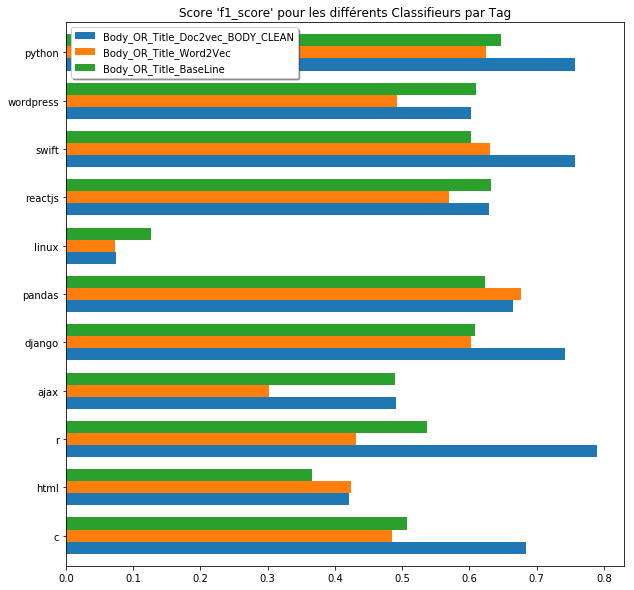

In [28]:
type_mesure = 'f1_score'

TOTAL_f1 = pd.concat(
    [
        resultat_body_clean_token.loc[l1_tag][[type_mesure]],
        m_df_Res_Title_OR_Body_V2.loc[l1_tag][[type_mesure]],
        m_df_logistic.loc[l1_tag][[type_mesure]]
    ], axis=1)

TOTAL_f1.columns = [
    'Body_OR_Title_Doc2vec_BODY_CLEAN', 
    'Body_OR_Title_Word2Vec', 
    'Body_OR_Title_BaseLine'
]

#TOTAL_f1.plot.barh(figsize=(10, 20), width=0.65)
TOTAL_f1.plot.barh(figsize=(10, 10), width=0.75)
plt.legend(loc='upper left', shadow=True)


plt.title("Score '{}' pour les différents Classifieurs par Tag".format(type_mesure))
plt.show()

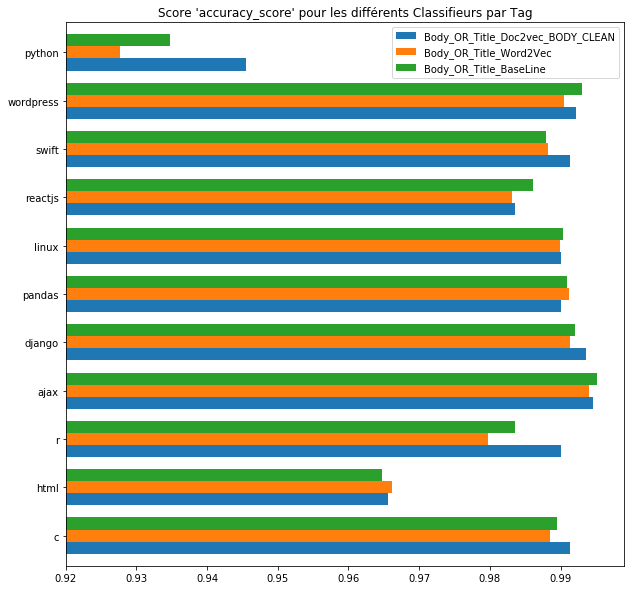

In [30]:
type_mesure = 'accuracy_score'

m_left = 0.92

TOTAL_f1 = pd.concat(
    [
        resultat_body_clean_token.loc[l1_tag][[type_mesure]]-m_left,
        m_df_Res_Title_OR_Body_V2.loc[l1_tag][[type_mesure]]-m_left,
        m_df_logistic.loc[l1_tag][[type_mesure]]-m_left
    ], axis=1)

TOTAL_f1.columns = [
    'Body_OR_Title_Doc2vec_BODY_CLEAN', 
    'Body_OR_Title_Word2Vec', 
    'Body_OR_Title_BaseLine'
]

#TOTAL_f1.plot.barh(figsize=(10, 20), width=0.65)
TOTAL_f1.plot.barh(figsize=(10, 10), width=0.75, left=m_left)

plt.title("Score '{}' pour les différents Classifieurs par Tag".format(type_mesure))
plt.show()

In [26]:
resultat_body_clean_token.loc['python']

f1_score          0.756588
recall            0.754902
accuracy_score    0.945500
Name: python, dtype: float64

In [32]:
m_df_logistic.loc['python']

f1_score          0.647218
recall            0.536258
accuracy_score    0.934700
Name: python, dtype: float64

In [ ]:
resultat_body_clean_token.loc[l1_tag][[type_mesure]]-m_left,
        m_df_Res_Title_OR_Body_V2.loc[l1_tag][[type_mesure]]-m_left,
        m_df_logistic.loc[l1_tag][[type_mesure]]-m_left